Import neccessary packages

In [51]:
from sklearn import linear_model
import numpy as np
import os

import xarray as xr
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report, r2_score

import sklearn.metrics as metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

Set variables

In [146]:
StepSize = 1 # how many output steps (months!) to predict over

halo_size = 1
halo_list = (range(-halo_size, halo_size+1))
#Calculate x,y position in each feature list to use as 'now' value
xy=2*(halo_size^2+halo_size) # if using a 2-d halo in x and y....if using a 3-d halo need to recalculate!

# region at start of run to learn from
split_index_yr=400
split_index = 12*split_index_yr   # learn from first 200 years

my_var = 'Ttave'
#my_var = 'uVeltave'

#my_var = 'Stave'
#my_var = 'uVeltave'

exp_name=my_var+'_tr'+str(split_index_yr)+'_halo'+str(halo_size)+'_pred'+str(StepSize)



Read in the data

In [147]:
DIR = '/data/hpcdata/users/racfur/MITGCM_OUTPUT/'
exp_list = ['20000yr_Windx1.00_mm_diag/']
file_list =[]
for exp in exp_list:
    for filename in os.listdir(os.path.join(DIR,exp)):
        if filename.__contains__('cat_tave_selectvars.nc'):
            file_list.append(os.path.join(DIR,exp,filename))

print(file_list)

ds   = xr.open_dataset(file_list[0])

ds_var=ds[my_var]

['/data/hpcdata/users/racfur/MITGCM_OUTPUT/20000yr_Windx1.00_mm_diag/cat_tave_selectvars.nc']


Plot time series of input (and output) data for a random point

In [148]:
# # Plot a timeseries of variable value at set grid point and its halo, 
# # to use this to predict the value of that variable at a later time step

# z=np.random.randint(halo_size,41-halo_size) # 42 points in z-dir - skip edge points, don't want to be near surface or bottom boundary *for now*.
# x=np.random.randint(halo_size,10-1-halo_size)  # 11 points in x dir - skip edge points to allow non-boundary halo - skip extra point as its land
# y=np.random.randint(halo_size,77-1-halo_size)  # 78 points in y dir - skip edge points to allow non-boundary halo - skip extra point as its land

# colours=['blue' , 'green', 'red', 'cyan', 'magenta', 'yellow', 'orange', 'purple', 'aquamarine',
#          'gold', 'brown', 'pink', 'grey', 'olive', 'yellowgreen', 'violet', 'teal', 'sienna',
#          'salmon', 'plum', 'navy', 'orangered', 'tan', 'lightblue', 'khaki', 'indigo', 
#          'darkgreen', 'crimson']
# colours.insert(xy, 'black')
# styles=['dotted'] * 28
# styles.insert(xy, 'solid')
# alphas=[0.4] * 28
# alphas.insert(xy, 1.)
# thicks=['0.5'] * 28
# thicks.insert(xy, '2')

# fig1 = plt.figure(figsize=(18,4))
# i=0
# for x_offset in halo_list:
#     for y_offset in halo_list:
#         ds_var[:split_index,z,y+y_offset,x+x_offset].plot(label=('x+%d,y+%d' % (x_offset, y_offset)), 
#                                                           alpha=1.0, xscale='log', color=colours[i], lw=thicks[i])
#         ds_var[split_index:,z,y+y_offset,x+x_offset].plot(alpha=0.4, xscale='log', color=colours[i], lw=thicks[i])
#         plt.xlabel('model time [s] (log scale)')
#         i=i+1

# fig1.legend(loc='center right')
# fig1.savefig('../regression_plots/'+exp_name+'_'+str(x)+'.'+str(y)+'.'+str(z)+'.png')

Read in data as training and test data

In [149]:
inputs_tr = []
nxt_outputs_tr = []

inputs_te = []
nxt_outputs_te = []

# Read in as training and test data (rather than reading in all data and splitting),
# so we can learn on first n time steps, and test on rest

for z in range(1,40,10):
    for x in range(2,7,3):
        for y in range(2,74,10):
            for time in range(0, split_index, 20):
                inputs_tr.append([ds_var.isel(T=time)[z,y+y_offset,x+x_offset] for x_offset in halo_list for y_offset in halo_list])
                nxt_outputs_tr.append([ds_var.isel(T=time+StepSize)[z,y,x]])
                
            for time in range(split_index, len(ds.T.data)-StepSize, 200):
                inputs_te.append([ds_var.isel(T=time)[z,y+y_offset,x+x_offset] for x_offset in halo_list for y_offset in halo_list])
                nxt_outputs_te.append([ds_var.isel(T=time+StepSize)[z,y,x]])
                
inputs_tr=np.asarray(inputs_tr)
nxt_outputs_tr=np.asarray(nxt_outputs_tr)

inputs_te=np.asarray(inputs_te)
nxt_outputs_te=np.asarray(nxt_outputs_te)

##calculate outputs for tendancy model as the difference between 'next' and 'now'
tnd_outputs_tr = nxt_outputs_tr[:,0] - inputs_tr[:,xy]
tnd_outputs_te = nxt_outputs_te[:,0] - inputs_te[:,xy]

print(inputs_tr.shape, nxt_outputs_tr.shape, tnd_outputs_tr.shape)
print(inputs_te.shape, nxt_outputs_te.shape, tnd_outputs_te.shape)

(15360, 9) (15360, 1) (15360,)
(36864, 9) (36864, 1) (36864,)


Check the data by outputting and plotting a few random samples

[1.7522569 2.2116716 2.85378   2.0303595 2.4663208 3.1156619 2.1318989
 2.6550796 3.3617496]
2.4663208
[2.465254]
-0.0010666847

[1.9953556 2.3186624 2.8564796 2.0412223 2.4684043 3.0885167 2.0498893
 2.6221354 3.3282468]
2.4684043
[2.4684172]
1.2874603e-05


(0, 4)

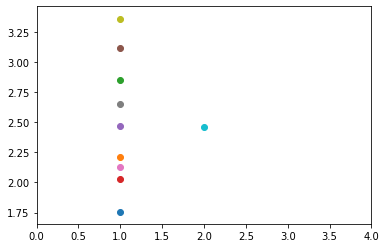

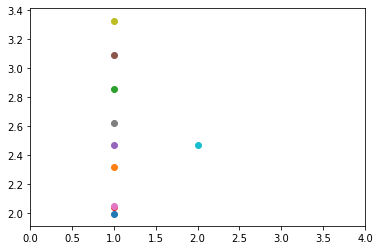

In [150]:
#output some random samples of test and train and plot

#sample_no=np.random.randint(0,inputs_tr.shape[0])
#print(sample_no)
sample_no=40
print(inputs_tr[sample_no,:])
print(inputs_tr[sample_no,xy])
print(nxt_outputs_tr[sample_no])
print(tnd_outputs_tr[sample_no])

features = range(inputs_tr.shape[1])
fig = plt.figure()
ax=plt.subplot()
for feature in features:
    plt.scatter(1,inputs_tr[sample_no,feature])
plt.scatter(2,nxt_outputs_tr[sample_no])
#plt.scatter(3,tnd_outputs_tr[sample_no])
ax.set_xlim(0,4)

#sample_no=np.random.randint(0,inputs_te.shape[0])
print('')
#print(sample_no)
sample_no=100
print(inputs_te[sample_no,:])
print(inputs_te[sample_no,xy])
print(nxt_outputs_te[sample_no])
print(tnd_outputs_te[sample_no])

features = range(inputs_te.shape[1])
fig = plt.figure()
ax=plt.subplot()
for feature in features:
    plt.scatter(1,inputs_te[sample_no,feature])
plt.scatter(2,nxt_outputs_te[sample_no])
#plt.scatter(3,tnd_outputs_te[sample_no])
ax.set_xlim(0,4)

Normalise Data

In [151]:
### Normalise (based on training data only)
def normalise_data(train,test):
    train_mean, train_std = np.mean(train), np.std(train)
    norm_train = (train - train_mean) / train_std
    norm_test  = (test - train_mean) / train_std
    return norm_train, norm_test

# normalise inputs
norm_inputs_tr = np.zeros(inputs_tr.shape)
norm_inputs_te = np.zeros(inputs_te.shape)

for i in range(inputs_tr.shape[1]):  #loop over each feature, normalising individually
    norm_inputs_tr[:, i], norm_inputs_te[:, i] = normalise_data(inputs_tr[:, i], inputs_te[:, i])

#normalise nxt and tnd outputs
norm_nxt_outputs_tr, norm_nxt_outputs_te = normalise_data(nxt_outputs_tr[:], nxt_outputs_te[:])
norm_tnd_outputs_tr, norm_tnd_outputs_te = normalise_data(tnd_outputs_tr[:], tnd_outputs_te[:])

# Calc mean and std of outputs re-forming predictions
nxt_outputs_tr_mean = np.mean(nxt_outputs_tr)
nxt_outputs_tr_std = np.std(nxt_outputs_tr)
tnd_outputs_tr_mean = np.mean(tnd_outputs_tr)
tnd_outputs_tr_std  = np.std(tnd_outputs_tr)
print(np.mean(nxt_outputs_tr))
print(np.std(nxt_outputs_tr))
print(np.mean(tnd_outputs_tr))
print(np.std(tnd_outputs_tr))


9.11406
7.608597
-3.663243e-05
0.0038221185


Set up a model to directly predict variable value at next time step

In [152]:
# First calculate and plot 'persistance' score, to give a baseline

predict_persistance_nxt = norm_inputs_te[:,xy]
print(predict_persistance_nxt.shape)

pers_nxt_r2 = r2_score(norm_nxt_outputs_te, predict_persistance_nxt)
pers_nxt_maxer = metrics.max_error(norm_nxt_outputs_te, predict_persistance_nxt)
pers_nxt_mse = metrics.mean_squared_error(norm_nxt_outputs_te, predict_persistance_nxt)

print('persistance r2 score ; ', pers_nxt_r2)
print('persistance max error ; ', pers_nxt_maxer)
print('persistance mean squared error ; ', pers_nxt_mse)

(36864,)
persistance r2 score ;  0.9999999926233658
persistance max error ;  0.002880491316318512
persistance mean squared error ;  7.288391700693818e-09


In [153]:
# Tune alpha using cross validation, and neg mean squared error

alpha_s = [0.00, 0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1.0, 3.0, 10, 30]

parameters = [{'alpha': alpha_s}]
n_folds=5
scoring={'max_error', 'neg_mean_squared_error', 'r2'}

model_nxt=linear_model.Ridge()

# Calculate training scores using cross validation with various values of alpha
model_nxt_cv = GridSearchCV(model_nxt, parameters, cv=n_folds, scoring=scoring, refit='neg_mean_squared_error')
model_nxt_cv.fit(norm_inputs_tr, norm_nxt_outputs_tr)
results = model_nxt_cv.cv_results_

best_params=model_nxt_cv.best_params_
best_alpha = (best_params['alpha'])


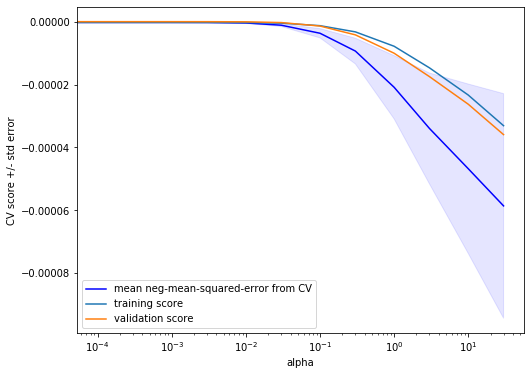

In [154]:
# For neg mean squared error, calculate and plot the mean score, and the region +/- one s.d
neg_mean_squared_error_mean = model_nxt_cv.cv_results_['mean_test_neg_mean_squared_error']
neg_mean_squared_error_std = model_nxt_cv.cv_results_['std_test_neg_mean_squared_error']
neg_mean_squared_error_std_error = neg_mean_squared_error_std / np.sqrt(n_folds)

plt.figure().set_size_inches(8, 6)
plt.semilogx(alpha_s, neg_mean_squared_error_mean, label='mean neg-mean-squared-error from CV', color='blue')
plt.fill_between(alpha_s, neg_mean_squared_error_mean + neg_mean_squared_error_std_error,
                 neg_mean_squared_error_mean - neg_mean_squared_error_std_error, alpha=0.1, color='blue')
plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
#plt.axhline(np.max(r2_scores), linestyle='--', color='.5')
# Also calculate training and validation scores for same values of alpha without CV 
# and overplot - seems there is something wrong here....
# The training scores should be similar... but are way out!
val_scores = []
train_scores = []
for alpha in alpha_s:
    model_nxt.set_params(alpha=alpha)
    model_nxt.fit(norm_inputs_tr, norm_nxt_outputs_tr)
    train_scores.append(- metrics.mean_squared_error(norm_nxt_outputs_tr, model_nxt.predict(norm_inputs_tr)) )
    val_scores.append(- metrics.mean_squared_error(norm_nxt_outputs_te, model_nxt.predict(norm_inputs_te)) )
plt.plot(alpha_s, train_scores, label='training score')
plt.plot(alpha_s, val_scores, label='validation score')
plt.legend()

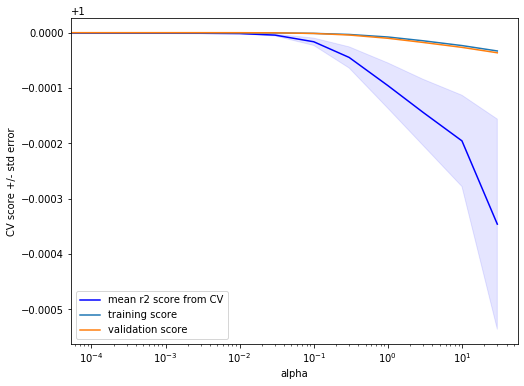

In [155]:
# For r2 score, calculate and plot the mean score, and the region +/- one s.d

r2_mean = model_nxt_cv.cv_results_['mean_test_r2']
r2_std = model_nxt_cv.cv_results_['std_test_r2']
r2_std_error = r2_std / np.sqrt(n_folds)

plt.figure().set_size_inches(8, 6)
plt.semilogx(alpha_s, r2_mean, label='mean r2 score from CV', color='blue')
plt.fill_between(alpha_s, r2_mean + r2_std_error, r2_mean - r2_std_error, alpha=0.1, color='blue')
plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
#plt.axhline(np.max(r2_scores), linestyle='--', color='.5')
# Also calculate training and validation scores for same values of alpha without CV 
# and overplot - seems there is something wrong here....
# The training scores should be similar... but are way out!
val_scores = []
train_scores = []
for alpha in alpha_s:
    model_nxt.set_params(alpha=alpha)
    model_nxt.fit(norm_inputs_tr, norm_nxt_outputs_tr)
    train_scores.append(model_nxt.score(norm_inputs_tr, norm_nxt_outputs_tr))
    val_scores.append(model_nxt.score(norm_inputs_te, norm_nxt_outputs_te))#
plt.plot(alpha_s, train_scores, label='training score')
plt.plot(alpha_s, val_scores, label='validation score')
plt.legend()

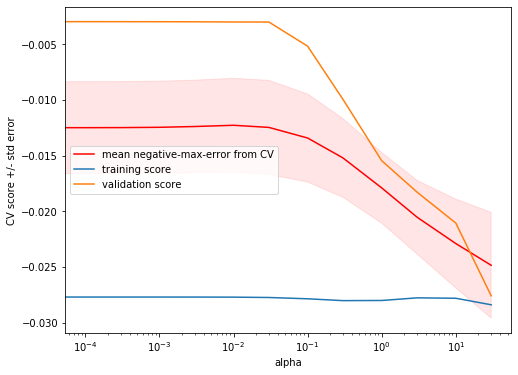

In [156]:
# For Max Error, plot the mean score, and the region +/- one s.d, (huge s.d. as you'd expect)
max_error_mean = model_nxt_cv.cv_results_['mean_test_max_error']
max_error_std = model_nxt_cv.cv_results_['std_test_max_error']
max_error_std_error = max_error_std / np.sqrt(n_folds)

plt.figure().set_size_inches(8, 6)
plt.semilogx(alpha_s, max_error_mean, label='mean negative-max-error from CV', color='red')
plt.fill_between(alpha_s, max_error_mean + max_error_std_error, max_error_mean - max_error_std_error, alpha=0.1, color='red')
plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
# Also calculate training and validation scores for same values of alpha without CV 
# and overplot - seems there is something wrong here....
# The training scores should be similar... but are way out!
val_scores = []
train_scores = []
for alpha in alpha_s:
    model_nxt.set_params(alpha=alpha)
    model_nxt.fit(norm_inputs_tr, norm_nxt_outputs_tr)
    train_scores.append(- metrics.max_error(norm_nxt_outputs_tr, model_nxt.predict(norm_inputs_tr)) )
    val_scores.append(- metrics.max_error(norm_nxt_outputs_te, model_nxt.predict(norm_inputs_te)) )
plt.plot(alpha_s, train_scores, label='training score')
plt.plot(alpha_s, val_scores, label='validation score')
plt.legend()

Having Tuned Alpha set up and run model

In [157]:
#run model, predict next time step value, and assess, having selected a best alpha from above using mean-square scores

model_nxt= linear_model.Ridge(alpha=best_alpha)
# eventually might want to aim for a zero intercept, but model seems to struggle a lot with this so leave for now

model_nxt.fit(norm_inputs_tr, norm_nxt_outputs_tr )  # train to evaluate the value at the next time step...

print('coefs     : ' + str(model_nxt.coef_))
print('intercept : ' + str(model_nxt.intercept_))
print(' ')

predicted_nxt = model_nxt.predict(norm_inputs_te)

nxt_r2 = r2_score(norm_nxt_outputs_te, predicted_nxt)
nxt_maxer = metrics.max_error(norm_nxt_outputs_te, predicted_nxt)
nxt_mse = metrics.mean_squared_error(norm_nxt_outputs_te, predicted_nxt)

print('persistance r2 score ; ', pers_nxt_r2)
print('persistance max error ; ', pers_nxt_maxer)
print('persistance mean squared error ; ', pers_nxt_mse)
print('')
print('model r2 score ; ', nxt_r2)
print('model max error ; ', nxt_maxer)
print('model mean squared error ; ', nxt_mse)


coefs     : [[-1.02726585e-03  2.94014665e-03 -2.33770771e-03  4.21804027e-04
   9.98691440e-01  1.64319202e-03  2.59701937e-03 -5.35020556e-03
   2.42762682e-03]]
intercept : [-5.14378175e-08]
 
persistance r2 score ;  0.9999999926233658
persistance max error ;  0.002880491316318512
persistance mean squared error ;  7.288391700693818e-09

model r2 score ;  0.999999991729379
model max error ;  0.0029552966086027754
model mean squared error ;  8.171684207695616e-09


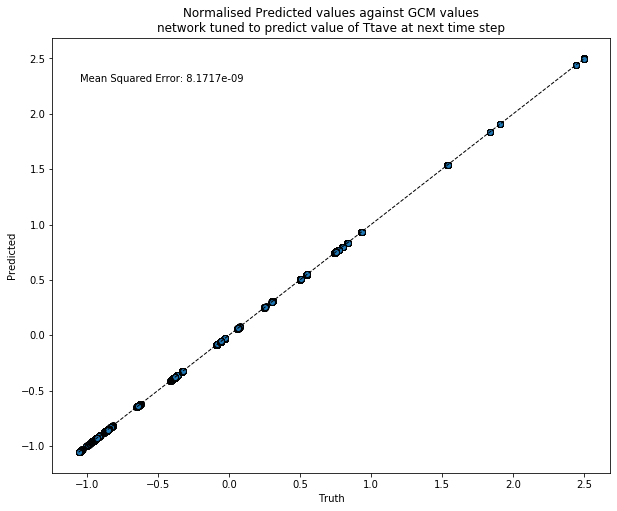

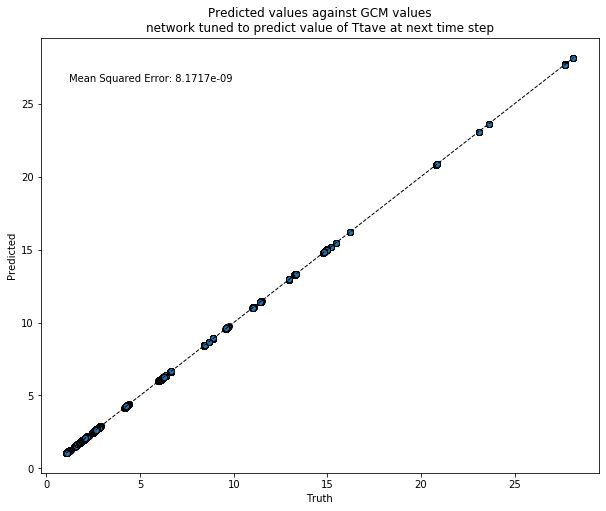

In [158]:
#first plot normalised prediction against truth
fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(norm_nxt_outputs_te, predicted_nxt, edgecolors=(0, 0, 0))
ax.plot([norm_nxt_outputs_te.min(), norm_nxt_outputs_te.max()], [norm_nxt_outputs_te.min(), norm_nxt_outputs_te.max()], 'k--', lw=1)
ax.set_xlabel('Truth')
ax.set_ylabel('Predicted')
ax.set_title('Normalised Predicted values against GCM values\nnetwork tuned to predict value of '+my_var+' at next time step')
ax.text(.05,.9,'Mean Squared Error: {:.4e}'.format(nxt_mse),transform=ax.transAxes)
plt.savefig('../regression_plots/'+exp_name+'_predictedVtruth_nxt.png')
plt.show()

#de-normalise predicted values and plot against truth

denorm_predicted_nxt = predicted_nxt*nxt_outputs_tr_std+nxt_outputs_tr_mean

fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(nxt_outputs_te, denorm_predicted_nxt, edgecolors=(0, 0, 0))
ax.plot([nxt_outputs_te.min(), nxt_outputs_te.max()], [nxt_outputs_te.min(), nxt_outputs_te.max()], 'k--', lw=1)
ax.set_xlabel('Truth')
ax.set_ylabel('Predicted')
ax.set_title('Predicted values against GCM values\nnetwork tuned to predict value of '+my_var+' at next time step')
ax.text(.05,.9,'Mean Squared Error: {:.4e}'.format(nxt_mse),transform=ax.transAxes)
plt.savefig('../regression_plots/'+exp_name+'_predictedVtruth_nxt.png')
plt.show()

Define a new model to predict tendancy (difference between now and next step)

In [159]:
# First calculate and plot 'persistance' score, to give a baseline

predict_persistance_tnd = np.zeros([tnd_outputs_te.shape[0]])

pers_tnd_r2 = r2_score(norm_tnd_outputs_te, predict_persistance_tnd)
pers_tnd_maxer = metrics.max_error(norm_tnd_outputs_te, predict_persistance_tnd)
pers_tnd_mse = metrics.mean_squared_error(norm_tnd_outputs_te, predict_persistance_tnd)

print('persistance r2 score ; ', pers_tnd_r2)
print('persistance max error ; ', pers_tnd_maxer)
print('persistance mean squared error ; ', pers_tnd_mse)

persistance r2 score ;  -0.004497935320049384
persistance max error ;  5.733948230743408
persistance mean squared error ;  0.02886610775155044


In [160]:
# Tune alpha using cross validation, and neg mean squared error

alpha_s = [0.00, 0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1.0, 3.0, 10, 30]

parameters = [{'alpha': alpha_s}]
n_folds=5
scoring={'max_error', 'neg_mean_squared_error', 'r2'}

model_tnd=linear_model.Ridge()

# Calculate training scores using cross validation with various values of alpha
model_tnd_cv = GridSearchCV(model_tnd, parameters, cv=n_folds, scoring=scoring, refit='neg_mean_squared_error')
model_tnd_cv.fit(norm_inputs_tr, norm_tnd_outputs_tr)
results = model_tnd_cv.cv_results_

best_params=model_tnd_cv.best_params_
best_alpha = (best_params['alpha'])


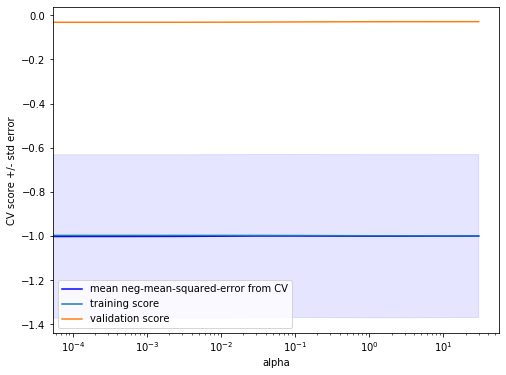

In [161]:
# For neg mean squared error, calculate and plot the mean score, and the region +/- one s.d
neg_mean_squared_error_mean = model_tnd_cv.cv_results_['mean_test_neg_mean_squared_error']
neg_mean_squared_error_std = model_tnd_cv.cv_results_['std_test_neg_mean_squared_error']
neg_mean_squared_error_std_error = neg_mean_squared_error_std / np.sqrt(n_folds)

plt.figure().set_size_inches(8, 6)
plt.semilogx(alpha_s, neg_mean_squared_error_mean, label='mean neg-mean-squared-error from CV', color='blue')
plt.fill_between(alpha_s, neg_mean_squared_error_mean + neg_mean_squared_error_std_error,
                 neg_mean_squared_error_mean - neg_mean_squared_error_std_error, alpha=0.1, color='blue')
plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
#plt.axhline(np.max(r2_scores), linestyle='--', color='.5')

# Also calculate training and validation scores for same values of alpha without CV 
# and overplot - seems there is something wrong here....
# The training scores should be similar... but are way out!
val_scores = []
train_scores = []
for alpha in alpha_s:
    model_tnd.set_params(alpha=alpha)
    model_tnd.fit(norm_inputs_tr, norm_tnd_outputs_tr)
    train_scores.append(- metrics.mean_squared_error(norm_tnd_outputs_tr, model_tnd.predict(norm_inputs_tr)) )
    val_scores.append(- metrics.mean_squared_error(norm_tnd_outputs_te, model_tnd.predict(norm_inputs_te)) )
plt.plot(alpha_s, train_scores, label='training score')
plt.plot(alpha_s, val_scores, label='validation score')
plt.legend()

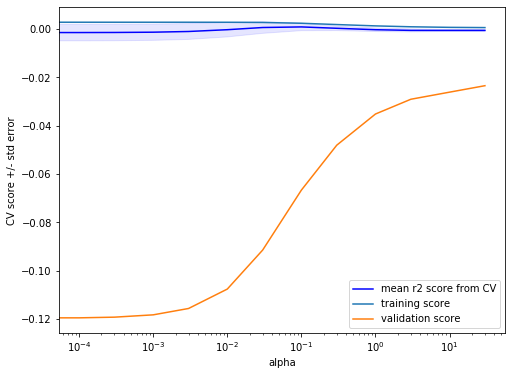

In [162]:
# For r2 score, calculate and plot the mean score, and the region +/- one s.d

r2_mean = model_tnd_cv.cv_results_['mean_test_r2']
r2_std = model_tnd_cv.cv_results_['std_test_r2']
r2_std_error = r2_std / np.sqrt(n_folds)

plt.figure().set_size_inches(8, 6)
plt.semilogx(alpha_s, r2_mean, label='mean r2 score from CV', color='blue')
plt.fill_between(alpha_s, r2_mean + r2_std_error, r2_mean - r2_std_error, alpha=0.1, color='blue')
plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
#plt.axhline(np.max(r2_scores), linestyle='--', color='.5')
# Also calculate training and validation scores for same values of alpha without CV 
# and overplot - seems there is something wrong here....
# The training scores should be similar... but are way out!
val_scores = []
train_scores = []
for alpha in alpha_s:
    model_tnd.set_params(alpha=alpha)
    model_tnd.fit(norm_inputs_tr, norm_tnd_outputs_tr)
    train_scores.append(model_tnd.score(norm_inputs_tr, norm_tnd_outputs_tr))
    val_scores.append(model_tnd.score(norm_inputs_te, norm_tnd_outputs_te))#
plt.plot(alpha_s, train_scores, label='training score')
plt.plot(alpha_s, val_scores, label='validation score')
plt.legend()

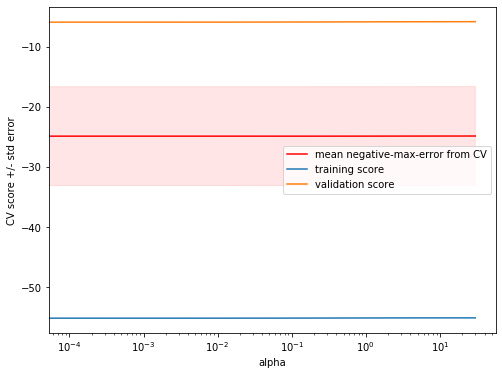

In [163]:
# For Max Error, plot the mean score, and the region +/- one s.d, (huge s.d. as you'd expect)
max_error_mean = model_tnd_cv.cv_results_['mean_test_max_error']
max_error_std = model_tnd_cv.cv_results_['std_test_max_error']
max_error_std_error = max_error_std / np.sqrt(n_folds)

plt.figure().set_size_inches(8, 6)
plt.semilogx(alpha_s, max_error_mean, label='mean negative-max-error from CV', color='red')
plt.fill_between(alpha_s, max_error_mean + max_error_std_error, max_error_mean - max_error_std_error, alpha=0.1, color='red')
plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
# Also calculate training and validation scores for same values of alpha without CV 
# and overplot - seems there is something wrong here....
# The training scores should be similar... but are way out!
val_scores = []
train_scores = []
for alpha in alpha_s:
    model_tnd.set_params(alpha=alpha)
    model_tnd.fit(norm_inputs_tr, norm_tnd_outputs_tr)
    train_scores.append(- metrics.max_error(norm_tnd_outputs_tr, model_tnd.predict(norm_inputs_tr)) )
    val_scores.append(- metrics.max_error(norm_tnd_outputs_te, model_tnd.predict(norm_inputs_te)) )
plt.plot(alpha_s, train_scores, label='training score')
plt.plot(alpha_s, val_scores, label='validation score')
plt.legend()

Having Tuned Alpha set up and run model

In [164]:
#run model to predict next time step value, having selected a best alpha from above, using r2 scores

model_tnd= linear_model.Ridge(alpha=best_alpha, normalize=False)
# eventually might want to aim for a zero intercept, but model seems to struggle a lot with this so leave for now

model_tnd.fit(norm_inputs_tr, norm_tnd_outputs_tr )  # train to evaluate the value at the next time step...

print('coefs     : ' + str(model_tnd.coef_))
print('intercept : ' + str(model_tnd.intercept_))
print(' ')

predicted_tnd = model_tnd.predict(norm_inputs_te)
tnd_r2 = r2_score(norm_tnd_outputs_te, predicted_tnd)
tnd_maxer = metrics.max_error(norm_tnd_outputs_te, predicted_tnd)
tnd_mse = metrics.mean_squared_error(norm_tnd_outputs_te, predicted_tnd)


print('persistance r2 score ; ', r2_score(norm_tnd_outputs_te, predict_persistance_tnd))
print('persistance max error ; ', metrics.max_error(norm_tnd_outputs_te, predict_persistance_tnd))
print('persistance mean squared error ; ', metrics.mean_squared_error(norm_tnd_outputs_te, predict_persistance_tnd))
print('')
print('model r2 score ; ', tnd_r2)
print('model max error ; ', tnd_maxer)
print('model mean squared error ; ', tnd_mse)


coefs     : [-0.08216033  2.03062076 -2.60545291  0.082384    0.19322093  1.37733432
  2.34387977 -6.4744498   3.13751289]
intercept : 9.190298862411857e-08
 
persistance r2 score ;  -0.004497935320049384
persistance max error ;  5.733948230743408
persistance mean squared error ;  0.02886610775155044

model r2 score ;  -0.06667365175352336
model max error ;  5.862117193444848
model mean squared error ;  0.030652842066267234


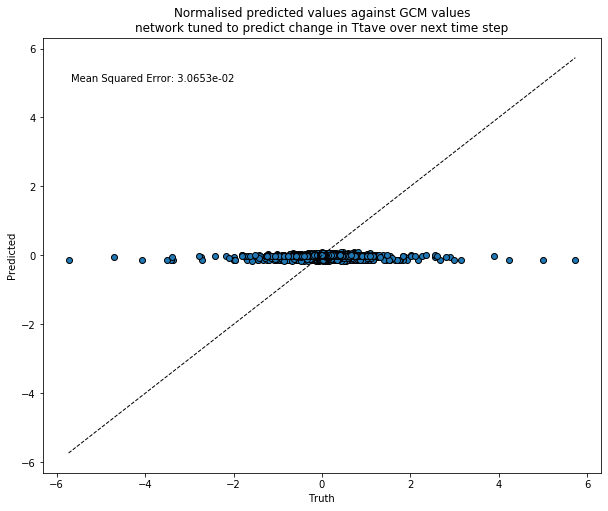

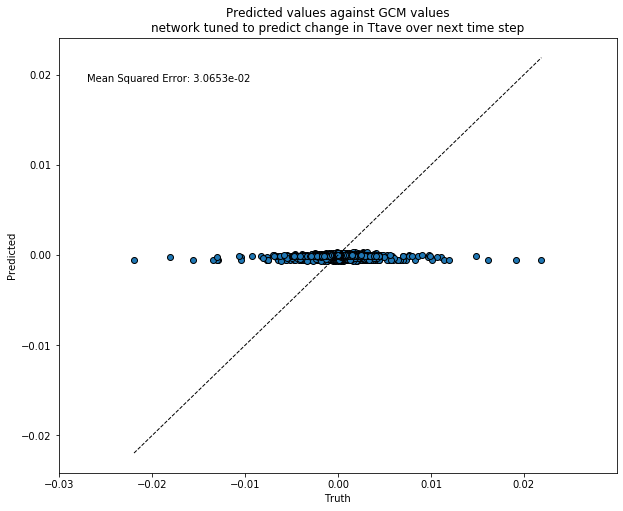

In [165]:
# first plot normalised values
fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(norm_tnd_outputs_te, predicted_tnd, edgecolors=(0, 0, 0))
ax.plot([norm_tnd_outputs_te.min(), norm_tnd_outputs_te.max()], [norm_tnd_outputs_te.min(), norm_tnd_outputs_te.max()], 'k--', lw=1)
ax.set_xlabel('Truth')
ax.set_ylabel('Predicted')
ax.set_title('Normalised predicted values against GCM values\nnetwork tuned to predict change in '+my_var+' over next time step')
ax.text(.05,.9,'Mean Squared Error: {:.4e}'.format(tnd_mse),transform=ax.transAxes)
plt.savefig('../regression_plots/'+exp_name+'_predictedVtruth_tnd.png')
plt.show()

#de-normalise predicted values and plot against truth

denorm_predicted_tnd = predicted_tnd*tnd_outputs_tr_std+tnd_outputs_tr_mean

fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(tnd_outputs_te, denorm_predicted_tnd, edgecolors=(0, 0, 0))
ax.plot([tnd_outputs_te.min(), tnd_outputs_te.max()], [tnd_outputs_te.min(), tnd_outputs_te.max()], 'k--', lw=1)
ax.set_xlabel('Truth')
ax.set_ylabel('Predicted')
ax.set_title('Predicted values against GCM values\nnetwork tuned to predict change in '+my_var+' over next time step')
ax.text(.05,.9,'Mean Squared Error: {:.4e}'.format(tnd_mse),transform=ax.transAxes)
if my_var=='uVeltave':
    plt.xlim(-0.001,0.001)
    plt.ylim(-0.001,0.001)
plt.savefig('../regression_plots/'+exp_name+'_predictedVtruth_tnd.png')
plt.show()

In [166]:
# Print all scores in one place, and to file:

print('next persistance r2 score ; ', pers_nxt_r2)
print('next persistance max error ; ', pers_nxt_maxer)
print('next persistance mean squared error ; ', pers_nxt_mse)
print('')
print('next model r2 score ; ', nxt_r2)
print('next model max error ; ', nxt_maxer)
print('next model mean squared error ; ', nxt_mse)
print('')
print('tend persistance r2 score ; ', r2_score(norm_tnd_outputs_te, predict_persistance_tnd))
print('tend persistance max error ; ', metrics.max_error(norm_tnd_outputs_te, predict_persistance_tnd))
print('tend persistance mean squared error ; ', metrics.mean_squared_error(norm_tnd_outputs_te, predict_persistance_tnd))
print('')
print('tend model r2 score ; ', tnd_r2)
print('tend model max error ; ', tnd_maxer)
print('tend model mean squared error ; ', tnd_mse)

file=open('../regression_plots/'+exp_name+'.txt',"w+")
file.write('mean_nxtoutputs %.10f; \n' % np.mean(nxt_outputs_tr))
file.write('std_nxtoutputs .10f; \n' % np.std(nxt_outputs_tr))
file.write('mean_tndoutputs .10f; \n' % np.mean(tnd_outputs_tr))
file.write('std_tndoutputs .10f; \n' % np.std(tnd_outputs_tr))
file.write('\n')
file.write('next persistance r2 score %.10f; \n' % pers_nxt_r2)
file.write('next persistance max error %.4f; \n' % pers_nxt_maxer)
file.write('next persistance mean squared error %.4e; \n' % pers_nxt_mse)
file.write('next persistance rms error %.4e; \n' % np.sqrt(pers_nxt_mse))
file.write('\n')
file.write('next model r2 score %.10f; \n' %  nxt_r2)
file.write('next model max error %.4f; \n' %  nxt_maxer)
file.write('next model mean squared error %.4e; \n' % nxt_mse)
file.write('next model rms error %.4e; \n' % np.sqrt(nxt_mse))
file.write('\n')
file.write('tend persistance r2 score %.10f; \n' % pers_tnd_r2)
file.write('tend persistance max error %.4f; \n' % pers_tnd_maxer)
file.write('tend persistance mean squared error %.4e; \n' % pers_tnd_mse)
file.write('tend persistance rms error %.4E; \n' % np.sqrt(pers_tnd_mse))
file.write('\n')
file.write('tend model r2 score %.10f; \n' % tnd_r2)
file.write('tend model max error %.4f; \n' % tnd_maxer)
file.write('tend model mean squared error %.4e; \n' % tnd_mse)
file.write('tend model rms error %.4e; \n' % np.sqrt(tnd_mse))
file.close() 

next persistance r2 score ;  0.9999999926233658
next persistance max error ;  0.002880491316318512
next persistance mean squared error ;  7.288391700693818e-09

next model r2 score ;  0.999999991729379
next model max error ;  0.0029552966086027754
next model mean squared error ;  8.171684207695616e-09

tend persistance r2 score ;  -0.004497935320049384
tend persistance max error ;  5.733948230743408
tend persistance mean squared error ;  0.02886610775155044

tend model r2 score ;  -0.06667365175352336
tend model max error ;  5.862117193444848
tend model mean squared error ;  0.030652842066267234


Attempts to bug fix code - something is wrong as test data always performs better than training data....?!?!

In [167]:
# # Results are suspicious... validation score should be worse than test, and should increase with alpha...
# # possible its due to the organised separation of test and train... investigate by combining train 
# # and test data and then randomly separating and running...

# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error, r2_score

# inputs = np.vstack((norm_inputs_tr, norm_inputs_te))
# outputs = np.vstack((norm_nxt_outputs_tr, norm_nxt_outputs_te))
# data = np.hstack((inputs, outputs))
# np.random.shuffle(data)

# #Split data into two sets
# in_set1, in_set2, out_set1, out_set2 = train_test_split(data[:,0:8], data[:,9:] , test_size=0.2, random_state=0)


In [168]:
# alpha_s = [0.00, 0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1.0, 3.0, 10, 30]

# #Run with set1 used as training data
# set1_test1 = []
# set2_test1 = []
# for alpha in alpha_s:
#     model_test1 = linear_model.Ridge(alpha=alpha)
#     # eventually might want to aim for a zero intercept, but model seems to struggle a lot with this so leave for now
#     # Fit model based on training data (and alpha)
#     model_test1.fit(in_set1, out_set1)
#     set1_test1.append(metrics.r2_score(model_test1.predict(in_set1), out_set1))
#     set2_test1.append(metrics.r2_score(model_test1.predict(in_set2), out_set2))
#     #set1_test1.append(model_test1.score(in_set1, out_set1))
#     #set2_test1.append(model_test1.score(in_set2, out_set2))
# # Do the plotting
# plt.figure(figsize=(15,10))
# plt.subplot(121)
# plt.semilogx(alpha_s, set1_test1, label='set1 score')
# plt.semilogx(alpha_s, set2_test1, label='set2 score')
# plt.ylabel('Score')
# plt.xlabel('Parameter alpha')
# plt.legend()

# #Redo with set2 used as training data
# set1_test2 = []
# set2_test2 = []
# for alpha in alpha_s:
#     model_test2 = linear_model.Ridge(alpha=alpha)
#     # Fit model based on *test* data (and alpha)
#     model_test2.fit(in_set2, out_set2)
#     #set1_test2.append(model_test2.score(in_set1, out_set1))
#     #set2_test2.append(model_test2.score(in_set2, out_set2))
#     set1_test2.append(metrics.r2_score(model_test2.predict(in_set1), out_set1))
#     set2_test2.append(metrics.r2_score(model_test2.predict(in_set2), out_set2))
# # Do the plotting
# plt.subplot(122)
# plt.semilogx(alpha_s, set1_test2, label='set1 score')
# plt.semilogx(alpha_s, set2_test2, label='set2 score')
# plt.ylabel('Score')
# plt.xlabel('Parameter alpha')
# plt.legend()

# plt.show()

# print([a_i - b_i for a_i, b_i in zip(set1_test2,set1_test1)])
# print([a_i - b_i for a_i, b_i in zip(set2_test2,set2_test1)])

In [145]:
# model_CV=linear_model.RidgeCV(alphas=alpha_s[1:]).fit(in_set1, out_set1)

# print(model_CV.score(in_set1, out_set1))
# print(model_CV.score(in_set2, out_set2))
# print( )
# model_CV=linear_model.RidgeCV(alphas=alpha_s[1:]).fit(in_set2, out_set2)

# print(model_CV.score(in_set1, out_set1))
# print(model_CV.score(in_set2, out_set2))